In [1]:
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import re, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(seed=42) 

In [2]:
DATADIR = "/DATA/ABCDFixRelease"
TASKDIR = "/DATA/ABCDTasks"

In [ ]:
paths = glob.glob("/DATA/ImageData/Data/*/ses-baselineYear1Arm1/anat/*T1w.nii.gz")

In [215]:
R = re.compile(r"Data\/sub-(.*)\/ses-")
clean = lambda x: x.strip().replace("_", "")

with open("val_keys.txt", "r") as f:
    inlier_keys = set([clean(x) for x in f.readlines()])

# next(iter(inlier_keys))

In [216]:
len(inlier_keys)

789

In [36]:
file_paths = {}
for path in paths: #filter(R.search, paths):
    match = R.search(path)
    sub_id = match.group(1)
    print(sub_id, sub_id in inlier_keys, path)
    file_paths[sub_id] = path
    if sub_id in inlier_keys:
        break

NDARINVVM3WVMV7 True /DATA/ImageData/Data/sub-NDARINVVM3WVMV7/ses-baselineYear1Arm1/anat/sub-NDARINVVM3WVMV7_ses-baselineYear1Arm1_run-01_T1w.nii.gz


In [37]:
len(file_paths)

1

In [38]:
t1_path = path
t2_path = path.replace("T1w", "T2w")

In [42]:
t2_path

'/DATA/ImageData/Data/sub-NDARINVVM3WVMV7/ses-baselineYear1Arm1/anat/sub-NDARINVVM3WVMV7_ses-baselineYear1Arm1_run-01_T2w.nii.gz'

In [77]:
import ants, antspynet

def getbbox(data):
    
    x = np.any(data, axis=(1,2)) # Returns true for every nonzero element 
    y = np.any(data, axis=(0,2))
    z = np.any(data, axis=(0,1)) 

    xmin, xmax = x.nonzero()[0][[0, -1]] # (xmin,0,0 to xmax,0,0 )
    ymin, ymax = y.nonzero()[0][[0, -1]]
    zmin, zmax = z.nonzero()[0][[0, -1]]
    
    return np.array([xmin,ymin,zmin,xmax,ymax,zmax])

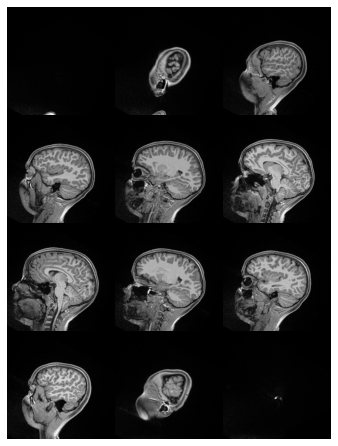

In [40]:
t1_img = ants.image_read(t1_path)
t2_img = ants.image_read(t2_path)
ants.plot(t1_img)

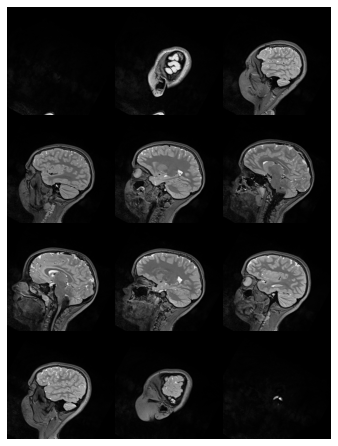

In [41]:
ants.plot(t2_img)

In [51]:
CACHE_DIR = os.getcwd() + "/template_cache"
CACHE_DIR

'/home/braintyp/dataset/template_cache'

In [66]:
ants_mni = ants.image_read(f"{CACHE_DIR}/croppedMni152.nii.gz")
ants_mni

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [80]:
ants_mni_full =  ants.image_read(f"{CACHE_DIR}/S_template3.nii.gz")
ants_mni_full

ANTsImage (LAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (136, 176, 176)
	 Spacing    : (1.5022, 1.4571, 1.4571)
	 Origin     : (202.8, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0.  1.  0.  0.  0.  1.]

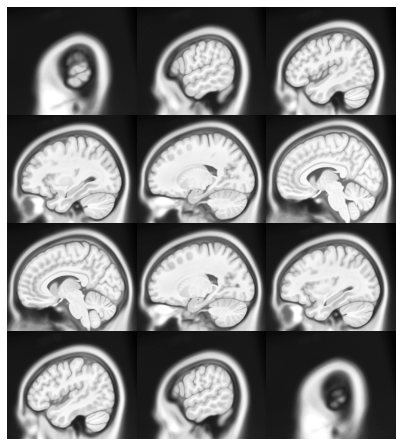

In [67]:
ants.plot(ants_mni)

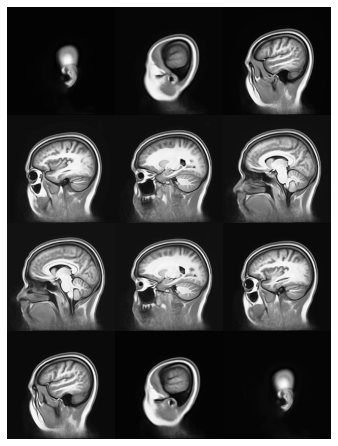

In [81]:
ants.plot(ants_mni_full)

In [131]:
%%time
processed_t1 = antspynet.utilities.preprocess_brain_image(t1_img,
                                                       truncate_intensity=(0.01, 0.99),
                                                       brain_extraction_modality="t1",
                                                       template_transform_type=None,
                                                       template='croppedMni152',
                                                       do_denoising=False,
                                                    do_bias_correction=False,
                                                       antsxnet_cache_directory=CACHE_DIR,
                                                       verbose=False)

processed_t2 = antspynet.utilities.preprocess_brain_image(t2_img,
                                                       truncate_intensity=(0.01, 0.99),
                                                       brain_extraction_modality="t2",
                                                       template_transform_type=None,
                                                       template='croppedMni152',
                                                       do_denoising=False, do_bias_correction=False,
                                                       antsxnet_cache_directory=CACHE_DIR,
                                                       verbose=False)
processed.keys()

1482752/1469496 [==============================] - 5s 4us/step
CPU times: user 3min 18s, sys: 1min 13s, total: 4min 31s
Wall time: 1min 36s


dict_keys(['preprocessed_image', 'brain_mask'])

In [134]:
(processed["brain_mask"] == processed["brain_mask"]).numpy().all()

True

In [136]:
(processed_t1["brain_mask"] == processed_t2["brain_mask"])

ANTsImage (RSP)
	 Pixel Type : unsigned char (uint8)
	 Components : 1
	 Dimensions : (256, 256, 256)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-128.0, 128.0, 128.0)
	 Direction  : [ 1.  0.  0.  0. -0. -1.  0. -1.  0.]

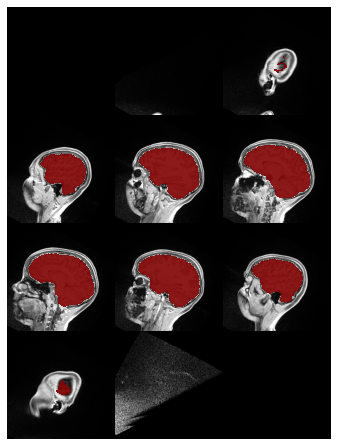

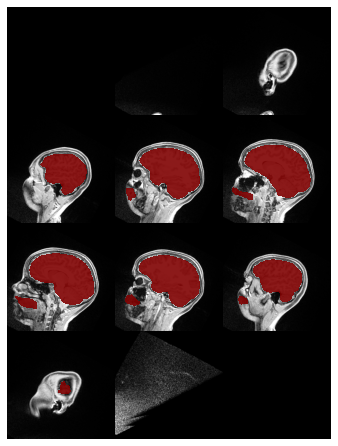

In [137]:
ants.plot(processed_t1["preprocessed_image"], overlay= processed_t1["brain_mask"])
ants.plot(processed_t1["preprocessed_image"], overlay= processed_t2["brain_mask"])

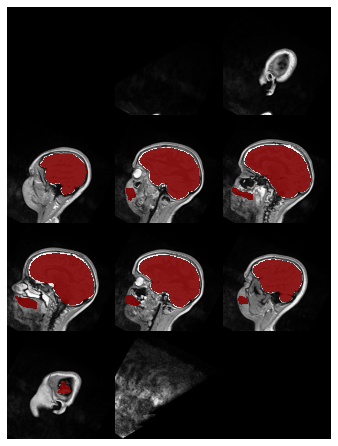

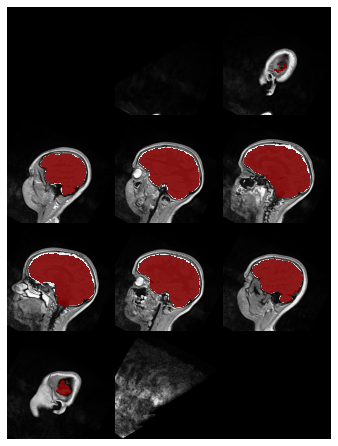

In [138]:
ants.plot(processed_t2["preprocessed_image"], overlay= processed_t2["brain_mask"])
ants.plot(processed_t2["preprocessed_image"], overlay= processed_t1["brain_mask"])

In [139]:
%%time
t1_mask = processed_t1["brain_mask"]
t2_mask = processed_t2["brain_mask"]

brain_extraction_combined = ants.iMath_fill_holes(ants.iMath_get_largest_component(t1_mask, t2_mask))

CPU times: user 38.4 s, sys: 27.6 s, total: 1min 5s
Wall time: 34.4 s


In [142]:
(brain_extraction_combined == t1_mask).numpy().all()

True

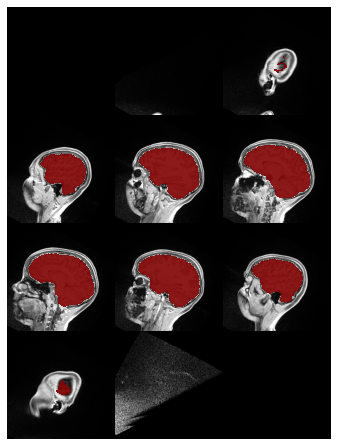

In [140]:
ants.plot(processed_t1["preprocessed_image"], overlay= brain_extraction_combined)

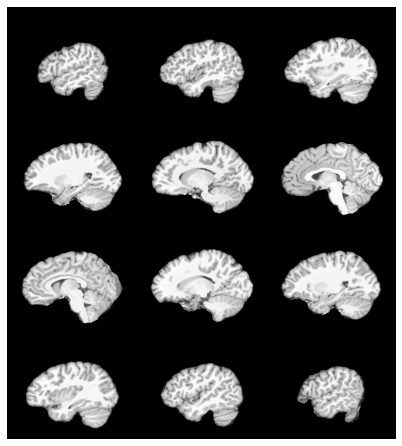

In [53]:
ants.plot(processed["preprocessed_image"] * processed["brain_mask"])

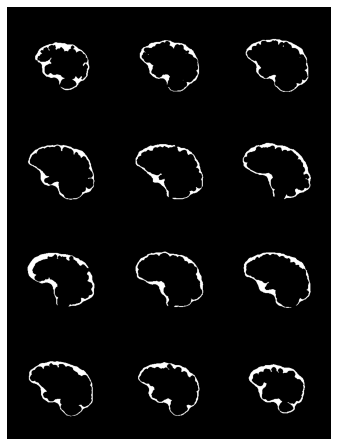

In [122]:
ants.plot(processed["brain_mask"])

In [117]:
ants.plot(processed["preprocessed_image"] * (processed["brain_mask"]))

TypeError: unsupported operand type(s) for -: 'float' and 'ANTsImage'

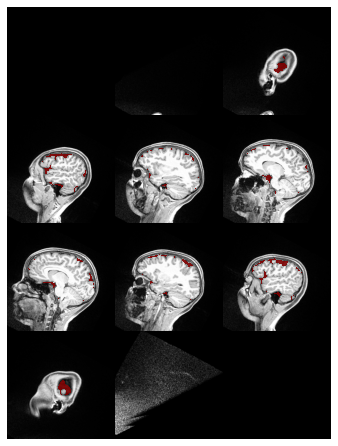

In [113]:
ants.plot(processed["preprocessed_image"], overlay=processed["brain_mask"])

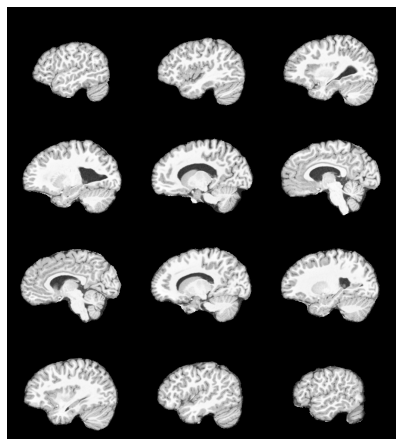

In [30]:
proc_img = processed["preprocessed_image"] * processed["brain_mask"]
ants.plot(proc_img)

In [64]:
T1_REF_IMG_PATH = os.path.join(CACHE_DIR,"mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a.nrrd")
T2_REF_IMG_PATH = os.path.join(CACHE_DIR,"mni_icbm152_09a/mni_icbm152_t2_tal_nlin_sym_09a.nrrd")
MASK_REF_IMG_PATH = os.path.join(CACHE_DIR,"mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nrrd")

t1_ref_img = ants.image_read(T1_REF_IMG_PATH)
t2_ref_img = ants.image_read(T2_REF_IMG_PATH)
ref_img_mask = ants.image_read(MASK_REF_IMG_PATH)

In [82]:
t1_ref_img, ants_mni

(ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (197, 233, 189)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (-196.0, -232.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 ANTsImage (LPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (182, 218, 182)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.])

In [83]:
bbox1 = getbbox(t1_ref_img.numpy())
bbox2 = getbbox(ants_mni.numpy())
bbox1, bbox2

(array([  0,   0,   0, 196, 232, 188]), array([  0,   0,   0, 181, 217, 181]))

In [92]:
# Use ANTs' tighter cropping
diff = np.array(t1_ref_img.shape) - np.array(ants_mni.shape)
crop_idxs_start, crop_idxs_end = 1+diff//2, np.array(t1_ref_img.shape)-diff//2
crop_idxs_start, crop_idxs_end

(array([8, 8, 4]), array([190, 226, 186]))

In [96]:
t1_ref_img = ants.crop_indices(t1_ref_img, crop_idxs_start, crop_idxs_end )
t2_ref_img = ants.crop_indices( t2_ref_img, crop_idxs_start, crop_idxs_end )
ref_img_mask =  ants.crop_indices(ref_img_mask, crop_idxs_start, crop_idxs_end )

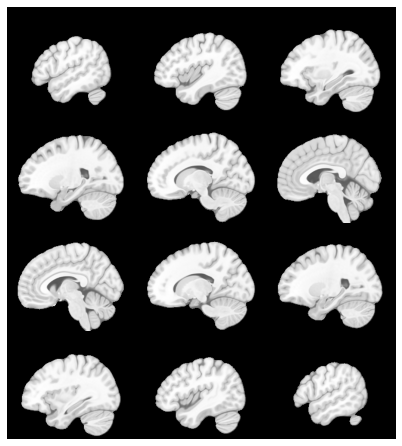

In [97]:
ants.plot(t1_ref_img * ref_img_mask)

In [218]:
stripped = t1_ref_img * ref_img_mask
print(np.any(stripped[:,0,0]) or np.any(stripped[:,-1,-1]))
print(np.any(stripped[0,:,0]) or np.any(stripped[-1,:,-1]))
print(np.any(stripped[0,0,:]) or np.any(stripped[-1:,:,]))

False

In [ ]:
np.any(stripped[:,0,0])

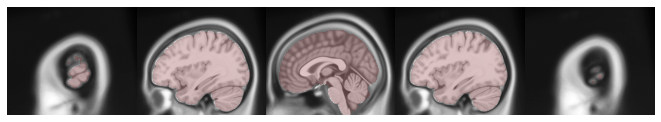

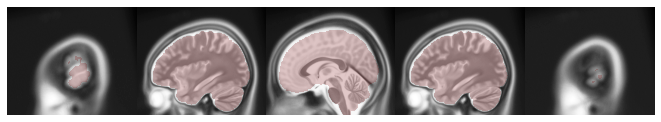

In [107]:
ants.plot(t1_ref_img, overlay=ref_img_mask, overlay_alpha=0.2, nslices=5)
ants.plot(t2_ref_img, overlay=ref_img_mask, overlay_alpha=0.2, nslices=5)

In [110]:
t1_ref_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-188.0, -224.0, 4.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [21]:
preproc_img = ants.utils.histogram_match_image(proc_img, t1_ref_img,
                                 number_of_histogram_bins=128,
                                 number_of_match_points=10
                                )
# Min max norm
preproc_img = (preproc_img - preproc_img.min())/ (preproc_img.max()-preproc_img.min())

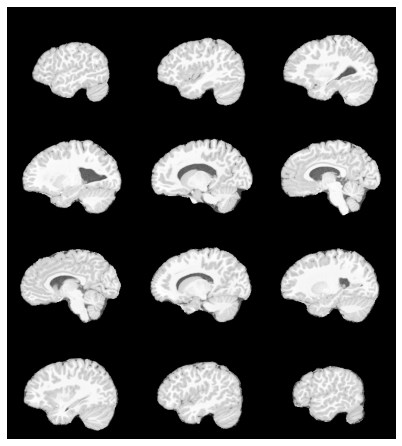

In [22]:
ants.plot(preproc_img)

### Only brain extraction and registration


In [174]:
def extract_brain_mask(image,
                       antsxnet_cache_directory=None,
                       verbose=True
                      ):
    from antspynet.utilities import brain_extraction
    
    if antsxnet_cache_directory == None:
        antsxnet_cache_directory = "ANTsXNet"

    # Truncating intensity as a preprocessing step following the original ants function
    preprocessed_image = ants.image_clone(image)
    truncate_intensity=(0.01, 0.99)
    if truncate_intensity is not None:
        quantiles = (image.quantile(truncate_intensity[0]), image.quantile(truncate_intensity[1]))
        if verbose == True:
            print("Preprocessing:  truncate intensities ( low =", quantiles[0], ", high =", quantiles[1], ").")

        preprocessed_image[image < quantiles[0]] = quantiles[0]
        preprocessed_image[image > quantiles[1]] = quantiles[1]
    
    # Brain extraction
    mask = None
    probability_mask = brain_extraction(preprocessed_image, modality="t1",
        antsxnet_cache_directory=antsxnet_cache_directory, verbose=verbose)
    mask = ants.threshold_image(probability_mask, 0.5, 1, 1, 0)
    mask = ants.morphology(mask,"close",6).iMath_fill_holes()
    
    return mask

def register_and_match(image, mask,
                       truncate_intensity=(0.01, 0.99),
                       modality="t1",
                       template_transform_type="Rigid",
                       antsxnet_cache_directory=None,
                       verbose=True):

    """
    Basic preprocessing pipeline for T1-weighted brain MRI adapted from AntsPyNet
    https://github.com/ANTsX/ANTsPyNet/blob/master/antspynet/utilities/brain_extraction.py
    
    Arguments
    ---------
    image : ANTsImage
        input image

    truncate_intensity : 2-length tuple
        Defines the quantile threshold for truncating the image intensity

    modality : string or None
        Modality that defines registration and brain extraction using antspynet tools.
        One of "t1" or "t2"
        
    template_transform_type : string
        See details in help for ants.registration.  Typically "Rigid" or
        "Affine".
    antsxnet_cache_directory : string
        Destination directory for storing the downloaded template and model weights.
        Since these can be resused, if is None, these data will be downloaded to a
        ~/.keras/ANTsXNet/.

    verbose : boolean
        Print progress to the screen.

    Returns
    -------
    Dictionary with preprocessing information ANTs image (i.e., source_image) matched to the
    (reference_image).

    Example
    -------
    >>> import ants
    >>> image = ants.image_read(ants.get_ants_data('r16'))
    >>> preprocessed_image = preprocess_brain_image(image, do_brain_extraction=False)
    """

    from antspynet.utilities import get_antsxnet_data

    assert modality in ["t1", "t2"]
    
    preprocessed_image = ants.image_clone(image)

    if antsxnet_cache_directory == None:
        antsxnet_cache_directory = "ANTsXNet"

    # Truncate intensity
    if truncate_intensity is not None:
        quantiles = (image.quantile(truncate_intensity[0]), image.quantile(truncate_intensity[1]))
        if verbose == True:
            print("Preprocessing:  truncate intensities ( low =", quantiles[0], ", high =", quantiles[1], ").")

        preprocessed_image[image < quantiles[0]] = quantiles[0]
        preprocessed_image[image > quantiles[1]] = quantiles[1]

    # Template normalization
    transforms = None
    if modality == "t1":
        template_image = t1_ref_img
    else:
        template_image = t2_ref_img

    template_brain_image = template_image * ref_img_mask

    preprocessed_brain_image = preprocessed_image * mask
    registration = ants.registration(fixed=template_brain_image, moving=preprocessed_brain_image,
        type_of_transform=template_transform_type, verbose=verbose)
    transforms = dict(fwdtransforms=registration['fwdtransforms'],
                      invtransforms=registration['invtransforms'])

    preprocessed_image = ants.apply_transforms(fixed = template_image, moving = preprocessed_image,
            transformlist=registration['fwdtransforms'], interpolator="linear", verbose=verbose)
    mask = ants.apply_transforms(fixed = template_image, moving = mask,
            transformlist=registration['fwdtransforms'], interpolator="genericLabel", verbose=verbose)

    # Do bias correction
    bias_field = None

    if verbose == True:
        print("Preprocessing:  brain correction.")
    n4_output = None
    n4_output = ants.n4_bias_field_correction(preprocessed_image, mask, 
                                              shrink_factor=4, return_bias_field=False, verbose=verbose)
    preprocessed_image = n4_output
    
    # Histogram matching with template
    preprocessed_image = preprocessed_image * mask
    preprocessed_image = ants.utils.histogram_match_image(preprocessed_image, template_brain_image,
                                 number_of_histogram_bins=128,
                                 number_of_match_points=10
                                )
    # Min max norm
    preprocessed_image = (preprocessed_image - preprocessed_image.min())/ (preprocessed_image.max()-preprocessed_image.min())
    
    return preprocessed_image

In [175]:
%%time
_mask = extract_brain_mask(t1_img, antsxnet_cache_directory=CACHE_DIR, verbose=False)
preproc_img = ants.merge_channels([
    register_and_match(t1_img, _mask, modality="t1", antsxnet_cache_directory=CACHE_DIR, verbose=False),
    register_and_match(t2_img, _mask, modality="t2", antsxnet_cache_directory=CACHE_DIR, verbose=False)]
)

CPU times: user 9min 56s, sys: 1min 12s, total: 11min 9s
Wall time: 1min 33s


In [176]:
preproc_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 2
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-188.0, -224.0, 4.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [197]:
preproc_img.to_filename('antstest4d.nii.gz')

In [194]:
%%time
import nibabel as nib

_nifti = preproc_img.to_nibabel()
nib.save(_nifti, 'test4d.nii.gz')  

CPU times: user 2.62 s, sys: 384 ms, total: 3.01 s
Wall time: 3.12 s


In [198]:
img = nib.load('antstest4d.nii.gz')
img.shape

(182, 218, 182, 1, 2)

In [209]:
img.get_data().squeeze().shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



(182, 218, 182, 2)

In [211]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  5 182 218 182   1   2   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : vector
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 188.0
qoffset_y       : 224.0
qoffset_z       : 4.0
srow_x          : [ -1.   0.   0. 188.]
srow_y  

In [203]:
img.affine

array([[ -1.,   0.,   0., 188.],
       [  0.,  -1.,   0., 224.],
       [  0.,   0.,   1.,   4.],
       [  0.,   0.,   0.,   1.]])

In [199]:
img_ants = ants.from_nibabel(img)
img_ants

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 2
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-188.0, -224.0, 4.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

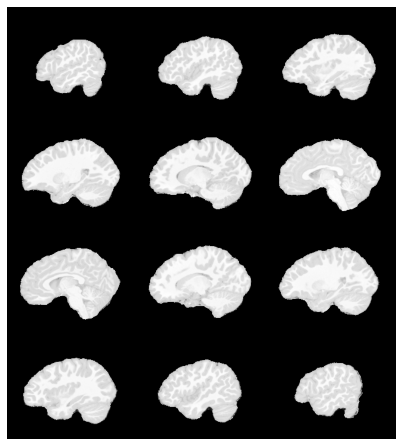

In [200]:
ants.plot(ants.split_channels(img_ants)[0])

In [181]:
preproc_img.numpy().shape

(182, 218, 182, 2)

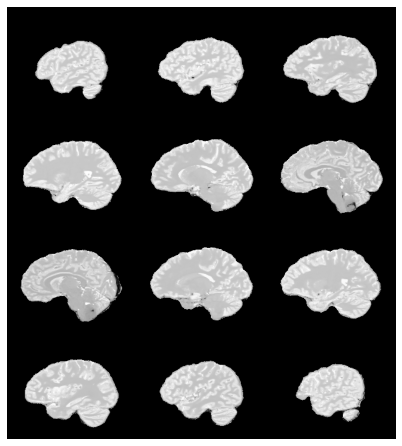

In [191]:
# ants.plot(ants.split_channels(preproc_img)[0], overlay=ants.split_channels(preproc_img)[1], overlay_alpha=0.2)
ants.plot(ants.split_channels(preproc_img)[1])

In [156]:
_mask_trunc = extract_brain_mask(t1_img, antsxnet_cache_directory=CACHE_DIR)

Preprocessing:  truncate intensities ( low = 0.22666060552001 , high = 113.66134071350098 ).
Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 3s 3s/step
Brain extraction:  renormalize probability mask to native space.


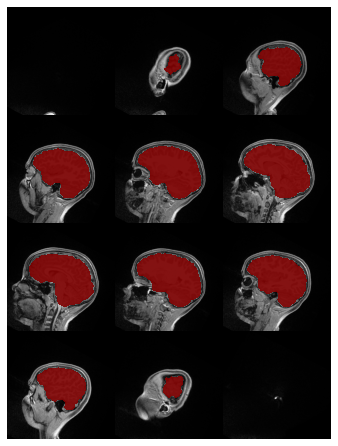

In [157]:
ants.plot(t1_img, overlay=_mask_trunc)

In [159]:
(_mask_trunc != _mask).numpy().sum()

13449

In [165]:
_mask_trunc.sum()/np.prod(_mask_trunc.shape) * 100

8.0433189868927

In [166]:
_mask.sum()/np.prod(_mask_trunc.shape) * 100

8.047676086425781

In [129]:
%%time
preproc_img = extract_and_register(t1_img, antsxnet_cache_directory=CACHE_DIR)
preproc_img

Preprocessing:  truncate intensities ( low = 0.22666060552001 , high = 113.66134071350098 ).
Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 3s 3s/step
Brain extraction:  renormalize probability mask to native space.
['-d', '3', '-i', '0x23000f20', '-o', '0x1dd94070', '-r', '0x2362a070', '-n', 'linear', '-t', '/tmp/tmp67fprmby0GenericAffine.mat']
['-d', '3', '-i', '0x350b3250', '-o', '0x1b505db0', '-r', '0x1e653d90', '-n', 'genericLabel', '-t', '/tmp/tmp67fprmby0GenericAffine.mat']
Preprocessing:  brain correction.
CPU times: user 5min 26s, sys: 53.2 s, total: 6min 20s
Wall time: 1min 3s


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-188.0, -224.0, 4.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

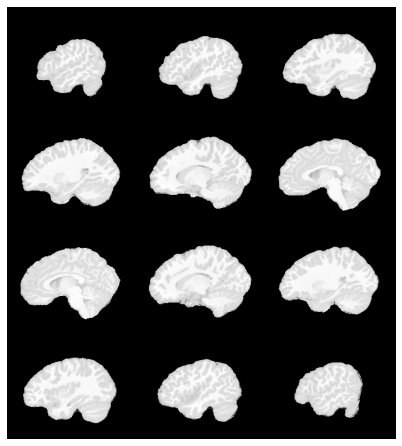

In [130]:
ants.plot(preproc_img)

In [ ]:
preproc_img_t2 = extract_and_register(t2_img, modality="t2", antsxnet_cache_directory=CACHE_DIR)
preproc_img_t2

In [ ]:
%%time

preproc_img = ants.merge_channels([
    extract_and_register(t1_img, antsxnet_cache_directory=CACHE_DIR),
    extract_and_register(t1_img, antsxnet_cache_directory=CACHE_DIR)]
)

In [34]:
t1_ref_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-196.0, -232.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [35]:
img

ANTsImage (RSP)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 256)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-128.0, 128.0, 128.0)
	 Direction  : [ 1.  0.  0.  0. -0. -1.  0. -1.  0.]

> Ants version looks smaller in dim 

In [32]:
proc_img

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [33]:
preproc_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-196.0, -232.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [44]:
img = ants.merge_channels([t1_img,t2_img])
ants.plot(img)

ValueError: Multi-component images only supported if they have 3 components